# Generating anyscript macros

The `generate_macros` packages contains tools to programtically write AnyBody macros. This simplifies the process of writing complex macros and makes it easier to do parameter studies. 

The package is imported with the following statement

In [1]:
from anypytools.generate_macros import MacroGenerator

The `MacroGenerator` class has methods for generating many of the standard AnyScipt macro commands.

- `add_load(mainfile, defines, paths)`: load command
- `add_run_operation(var)`: select operation and run  
- `add_dump(var)`: classoperation "Dump"
- `add_load_design(var, filename)`: classoperation "Load design" 
- `add_save_design(var, filename)`: classoperation "Save design" 
- `add_load_values(filename)`: classoperation Main "Load Values" 
- `add_save_values(filename)`: classoperation Main "Save Values"
- `add_update_values()`: classoperation "Update Values"
- `add_set_value(var,value)`: classoperation "Set Value" 
- `add_macro(macro)`: Add abitrary macro string

## Generate a macro

This following example show how to construct a very simple macro:

In [2]:
mg = MacroGenerator()

mg.add_load('Knee.any')
mg.add_run_operation('Main.MyStudy.InverseDynamics')
mg.add_dump('Main.MyStudy.Output.MaxMuscleActivity')
macro  = mg.generate_macros()

macro

[[u'load "Knee.any"',
  u'operation Main.MyStudy.InverseDynamics',
  u'run',
  u'classoperation Main.MyStudy.Output.MaxMuscleActivity "Dump"']]

We use the AnyPyProcess class to launch the macro

In [3]:
from anypytools.abcutils import AnyPyProcess 
app = AnyPyProcess()

output = app.start_macro( macro )

 [****************100%******************]  1 of 1 complete

## Creating many macros

The former macro could easily have been written manually. In some cases we want to create many macros. Then it is an big advantage to generate them programmatically. 

The `MacroGenerator` class have an argument which specifies how many macros to generate.

In [4]:
mg = MacroGenerator(number_of_macros=5)

mg.add_load('Knee.any')
mg.add_run_operation('Main.MyStudy.InverseDynamics')
macro_list = mg.generate_macros()
macro_list

[[u'load "Knee.any"', u'operation Main.MyStudy.InverseDynamics', u'run'],
 [u'load "Knee.any"', u'operation Main.MyStudy.InverseDynamics', u'run'],
 [u'load "Knee.any"', u'operation Main.MyStudy.InverseDynamics', u'run'],
 [u'load "Knee.any"', u'operation Main.MyStudy.InverseDynamics', u'run'],
 [u'load "Knee.any"', u'operation Main.MyStudy.InverseDynamics', u'run']]

This list of macros can also be passed to the 'start_macro' function to executed in parallel. 

In [5]:
output = app.start_macro( macro_list )

 [****************100%******************]  5 of 5 complete

This is only really usefull if the macros are different. Some methods, like `mg.add_set_value()`, accepts lists of values which is then distributed across the generated macros. 

Imagine a list of 5 parameters. We want to create five macros that uses these values:

In [6]:
parameter_list = [2.2, 2.5, 2.7, 2.9, 3.1]

mg = MacroGenerator(number_of_macros=5)
mg.add_set_value('Main.MyParameter',parameter_list )
mg.generate_macros()

[[u'classoperation Main.MyParameter "Set Value" --value="2.2"'],
 [u'classoperation Main.MyParameter "Set Value" --value="2.5"'],
 [u'classoperation Main.MyParameter "Set Value" --value="2.7"'],
 [u'classoperation Main.MyParameter "Set Value" --value="2.9"'],
 [u'classoperation Main.MyParameter "Set Value" --value="3.1"']]

## A simple parameter study

Let us combine the previous to create a parameter study. We will continue with the simplified knee model where we left of in the [previous tutorial](01 - Getting started with anypytools.ipynb#Getting-data-from-the-AnyBody-Model). The parameter study will vary the patella tendon length from 2.0cm to 8.0cm, and observe the effect on maximum muscle activity.

First we create a list of patella length parameters. 

In [7]:
patella_tendon_lengths = [0.02 + i*0.01 for i in range(7)]
print(patella_tendon_lengths)

[0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08]


This list of values is addded to the macros with the `add_set_value()` method. 

In [8]:
mg = MacroGenerator( number_of_macros = len(patella_tendon_lengths) )
mg.add_load('Knee.any')
mg.add_set_value('Main.MyModel.PatellaLigament.DriverPos', patella_tendon_lengths )
mg.add_run_operation('Main.MyStudy.InverseDynamics')
mg.add_dump('Main.MyStudy.Output.MaxMuscleActivity')
mg.add_dump('Main.MyModel.PatellaLigament.DriverPos')

We can now run the model and analyze the resulting maximum muscle activity by plotting the data in the `output` variable:

In [9]:
macros = mg.generate_macros()
output = app.start_macro( mg.generate_macros() )

 [****************100%******************]  7 of 7 complete

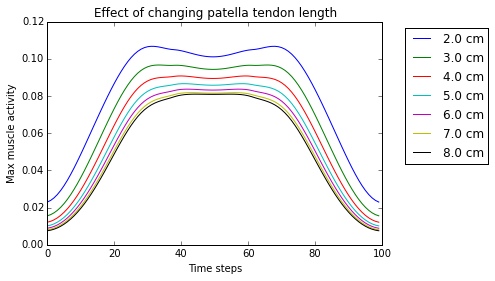

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

for data in output:
    maxact = data['Main.MyStudy.Output.MaxMuscleActivity']
    patella_length = data['Main.MyModel.PatellaLigament.DriverPos'][0]
    plt.plot(maxact, label='{:.1f} cm'.format(100*patella_length) )

plt.title('Effect of changing patella tendon length')    
plt.xlabel('Time steps')
plt.ylabel('Max muscle activity')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2);